In [3]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer
from nltk.corpus import stopwords
import regex as re
import requests
from logging import raiseExceptions
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import contractions
import nltk
from scipy import stats

import time
import spacy
import spacy.cli

pd.set_option('max_colwidth', 400)

# Data Collection

##### Get Submissions method

In [877]:
def get_submission(theme, requests_amount):
    list_submission=[]
    counter=0
    sum=0
    for x in range(1,requests_amount+1):
        url_topic_1=f"https://api.pushshift.io/reddit/search/submission/?subreddit={theme}&fields=selftext,removed_by_category&size=100&before={counter}d"
        req_1=requests.get(url_topic_1)
        #to avoid overrequesting API, code is waiting for a second after request
        time.sleep(1)

        if req_1.status_code==200:
            counter+=1
            sq=req_1.json()            
            for x in sq["data"]:
                #I am checking "removed by category" field, to exclude spam and inappropriate posts, deleted by bot.
                if "removed_by_category" not in x:
                    list_submission.append(x["selftext"])
                    sum+=1                
        else:
            print(f"There was a mistake {req_1.status_code}")
            return list_submission
    print(f"{sum} submissions downloaded")       
    return list_submission

##### Get commentaries method

In [1086]:
#processing url and getting list of comments

def get_comment(theme,quant):
    list_comments=[]
    counter=0
    for x in range(1,36,2):
        url_topic_1=f"https://api.pushshift.io/reddit/search/comment/?size={quant}&subreddit={theme}&before={x}d"
        req_1=requests.get(url_topic_1)
        if counter%2==0:
            #Waiting for a second each 2nd request
            time.sleep(1)
        if req_1.status_code==200:
            counter+=1
            sq=req_1.json()            
            for x in sq["data"]:
                list_comments.append(x['body'])                
        else:
            return f"Code was {req_1.status_code}"
    return list_comments

##### Cleaning with RegExp

In [1869]:
#using regexp to clean recieved comments
def clean(sq):
    sq=[x.lower() for x in sq if x.find("Your submission has been")==-1] #drops posts of antispam bot
    sq=[x.lower() for x in sq if x!="delete"] # drops posts with "delete" in them
    sq=[x.lower() for x in sq if x.find("title")==-1] 
    sq=[re.sub("(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)"," ", x.lower()) for x in sq] #drops all links
    sq=[re.sub("(.)\1{2}"," ", x.lower()) for x in sq] # drops all words where 3 or more same letters are put together like "aaaaand", "soooooo"
    sq=[re.sub("\W+"," ", x.lower()) for x in sq] #drops all whitespace symbols like \n \t etc.
    sq=[re.sub("\w*\d\w*"," ", x.lower()) for x in sq] #drops all words with numbers in them 
    sq=[re.sub("\s[a-z]{1,2}\s"," ", x.lower()) for x in sq] #drops all two letter words, because almost all of them are Stop-words
    sq=[re.sub("\s[a-z]{1,1}\s"," ", x.lower()) for x in sq] #drops all one letter words,for some reason previous regex left some of those
    sq=[re.sub("^i+(?!$)"," ", x.lower()) for x in sq] #drops fist letter if it is i
    sq=[x.lower().strip() for x in sq if x.find("removed")==-1] #drops "removed" comments, sent by api 
    sq=[re.sub("^m+(?!$)"," ", x.lower()) for x in sq] #drops fist letter if it is m
    sq=set(sq) #Leaving only unique values

    
    return sq


#### Downloading and cleaning commentaries

In [1088]:
AskMan_comment=get_comment("AskMen",130)
len(set(AskMan_comment))

2183

In [1089]:
AskWoman_comment=get_comment("AskWomen",130)
len(set(AskWoman_comment))

2096

##### Adding columns for classification and saving dataset

In [1104]:
AskMan_comment=clean(set(AskMan_comment))
AskMan_comment_df=pd.DataFrame(AskMan_comment)
AskMan_comment_df['sex']=1
AskMan_comment_df.columns=["comment",'sex']

AskWoman_comment=clean(set(AskWoman_comment))
AskWoman_comment_df=pd.DataFrame(AskWoman_comment)
AskWoman_comment_df['sex']=0
AskWoman_comment_df.columns=["comment",'sex']

AskMan_comment_df.shape, AskWoman_comment_df.shape

In [ ]:
final_comment_df=pd.concat([AskMan_comment_df,AskWoman_comment_df])
final_comment_df.reset_index(inplace=True,drop=True)
final_comment_df

final_comment_df.to_csv('../data/df_comments.csv',index=False)

----

#### Downloading Submissions

In [839]:
AskMan=get_submission("AskMen",130)


5335 submissions downloaded


In [840]:
len(set(AskMan))

2682

In [842]:
AskWoman=get_submission("AskWomen",130)
len(set(AskWoman))


5665 submissions downloaded


2080

In [1870]:
c_ask_man=clean(AskMan)
c_ask_woman=clean(AskWoman)
print(f"Unique AskMan comments:  {len(c_ask_man)}")
print(f"Unique AskWoman comments: {len(c_ask_woman)}")

Unique AskMan comments:  2599
Unique AskWoman comments: 2017


##### Adding target column for future classification

In [1871]:
df_cleaned_man=pd.DataFrame(data=c_ask_man)
df_cleaned_man["sex"]=1
df_cleaned_man.columns = ["comment","sex"]
df_cleaned_man=df_cleaned_man[df_cleaned_man["comment"]!=""]
df_cleaned_man


,comment,sex
1,every time tried get into relationship become disinterested the last second,1
2,have big crush her and she has boyfriend have one hand holding so afraid she gonna see what,1
3,with men that manipulate and gaslight girl what are your core intentions you even like the girl going through all that why can you just leave her alone are you even aware doing thanks,1
4,real examples hey council pick is friday will you home help move the bed frame the sidewalk not ll have switch shift also dinner plans steak pasta at the shops now male housemate steak sounds good sends meme first hey ll there when you clock off work also idk we should still invite given what happened tuesday might awks have friend amp ironed things out male friend haha sends meme back...,1
5,ok this situation happens lot where you are sitting with your friend and his friend and then friend leaves and now you both are just sitting there and one talking and just very awkward,1
...,...,...
2594,so for context ve been an off and relationship for very long time during all off times both were single broke all off our relationship and friendship like about half year ago and took like solid months get over her lately ve been feeling that miss her but pretty sure don really miss her more than that just miss the idea us and being relationship and love hope everything ve just said makes ...,1
2595,guy who had drinks some ocassion past relatives would ask to drink eventhough was just kid know that immoral anyways also that time used think cool after that used drink from dad bottle that used hide like once year and didn taste good all used drink feel intoxicated fast forward present drink again from his bottle yesterday and found still don like taste all hence ve always wondered that pe...,1
2596,let say you physically remain the same you are now and won age you live the age what would you within that time the average person lives the age and seems never has time do all the things one wants do however you could live for the next years what sort things would you,1
2597,probably bought over through the years where the heck they all,1


In [1872]:
df_cleaned_woman=pd.DataFrame(data=c_ask_woman)
df_cleaned_woman["sex"]="0"
df_cleaned_woman.columns = ["comment","sex"]
df_cleaned_woman=df_cleaned_woman[df_cleaned_woman["comment"]!=""]
df_cleaned_woman

,comment,sex
1,watching the rise skywalker tv wife said star wars guy thing and women don like said there are lot women that like,0
2,nterested send message looking for sine one quick,0
3,hello new here and would like make new friends and just have conversations ️ ️,0
4,something the heart your identity maybe quiet secret you wish someone else could recognize for what is show yourself some love and self appreciation today,0
5,ok my daughter having sleep over this weekend she asked to buy the facemasks facials that always get her she wants do them with the girls heres the problem they are the charcoal masks its say yes tomatoes charcoal mask she likes them because they peel off and its cool initially thought was problem but with how things are nowadays don know are very pale blondes and most the girls are white ...,0
...,...,...
2012,have you ever encountered any issues,0
2013,what you think about the thing where the person holds your face between their hands when they kiss you this supposed be super hot super romantic whatever just wondering what every one thinks,0
2014,usually just listen some music watch movie,0
2015,comment your to hookup outfits,0


##### Concatenating final united dataframe

In [1873]:
final_df=pd.concat([df_cleaned_man[:2056],df_cleaned_woman[:]],ignore_index=True)

In [1874]:
final_df.shape

(4072, 2)

In [1875]:
final_df.head()

,comment,sex
0,every time tried get into relationship become disinterested the last second,1
1,have big crush her and she has boyfriend have one hand holding so afraid she gonna see what,1
2,with men that manipulate and gaslight girl what are your core intentions you even like the girl going through all that why can you just leave her alone are you even aware doing thanks,1
3,real examples hey council pick is friday will you home help move the bed frame the sidewalk not ll have switch shift also dinner plans steak pasta at the shops now male housemate steak sounds good sends meme first hey ll there when you clock off work also idk we should still invite given what happened tuesday might awks have friend amp ironed things out male friend haha sends meme back...,1
4,ok this situation happens lot where you are sitting with your friend and his friend and then friend leaves and now you both are just sitting there and one talking and just very awkward,1


##### Checking for nulls and column types

In [1876]:
final_df.isnull().sum()

comment    0
sex        0
dtype: int64

In [1877]:
final_df.dtypes

comment    object
sex        object
dtype: object

"Sex" column is binary and should be int.

In [1878]:
final_df["sex"]=final_df["sex"].astype(int)
final_df.dtypes

comment    object
sex         int64
dtype: object

In [1980]:
#saving file
final_df.to_csv("../data/df_submissions_basic_clean.csv",index=False)

Code to restore dataframe without redownloading.

In [4]:
# final_df=pd.read_csv('../data/df_submissions_basic_clean.csv')

----

# EDA and Cleaning

##### Expanding Contractions

In [6]:
def expand(document):
    result=""
    for word in document.split(" "):        
        result+=contractions.fix(word)
        result+=" "
    return result.strip()

In [7]:
final_df['comment']=final_df['comment'].apply(lambda x: expand(x))

#### Processing with SpaCy 

(I didn't use pipelines, because I've used stages for modeling)

In [ ]:
spacy.cli.download('en_core_web_md')
nlp = spacy.load('en_core_web_md')

Lemmatizing each word and dropping auxilary words

In [9]:
def drop_aux(docs):
    cleaned=""
    nlp_doc=nlp(docs)
    for word in nlp_doc:
        if word.pos_!="AUX":
            cleaned+=str(word.lemma_)
            cleaned+=" "
    return cleaned.strip()


In [11]:
final_df['comment']=final_df["comment"].apply(lambda x: drop_aux(x))
final_df['comment']=final_df["comment"].apply(lambda x: drop_aux(x))
#Dropping all possible empty rows, which contained only aux
final_df=final_df[final_df["comment"]!=""]

----

##### Check for Sentiment Scores

In [12]:
sent= SentimentIntensityAnalyzer()

AskMan submissions

In [15]:
result=[]
for mcomment in final_df[final_df["sex"]==1]["comment"]:    
    score=sent.polarity_scores(mcomment)
    temp={"comment":mcomment,"score":score["compound"]}
    result.append(temp)
    # df_man_sentiment.append(temp,ignore_index=True)
df_man_sentiment=pd.DataFrame(data=result)

df_man_sentiment.sort_values(by=["score"],ascending=False)

,comment,score
85,worry that just deny because feel ashamed think lose this isn the case honest don have issue he want sleep with other girl understand some people just like that and want he happy use have issue with as lie I when find out hit this other woman while say want exclusive but don anymore however have issue with dishonesty also portray lot thing differently the begin our relationship like how strong...,0.9990
1597,a couple month ago one my friend call her tayla that in long term relationship mention one her guy friend call he she grow with single and she and her partner set up with he she show photo but say say sleep with another one our friend within the group call she jess back when they high school high school good year ago for but still uninterested see another guy fast forward this past sund...,0.9986
1205,so uni the group people talk about all live dorm campus re great group friend close friend guy and girl who somewhat interested but the less funny less attractive less interesting person she not interested I back accept the fate friendship which isn too bad itself but the guy interest she for quite some time and actively persue something out it and definitely have well chance tha...,0.9978
1351,so let start with little background work for company that around for year the guy that start the company start from the ground and build into company with over two hundred employee still the manager and there everyday for least ten hour the most inspiring passionate man ever know work there for year and develop very close friendship with the guy close that his wife plan his last ...,0.9977
546,first all great advice here and thank all date this girl for few date and far not go far than make out the advice people give here increase sexual inuendo and sexual tension work great general for with woman the past but not effective with this woman for example have inside joke where make bet and the loser dance like music video routine for the other person really just joke and not actually g...,0.9976
...,...,...
818,hi man reddit over the last year make conscious effort become assertive after many year poor treatment from various people my life take boxing practice strong eye contact quick make complaint about bad service etc long way go but slowly feel myself become less pushover and think people general little nice I maybe carry myself differently not know but something work however recent time develop ...,-0.9848
125,scenario you just get home after work and around midnight you tired but suddenly you hear your daughter son scream for help louder than you ever think possible and you run their bedroom where they asleep but the time you get there they dead the murderer stand above they hold the murder weapon you happen hold gun how you react for extra context you know for fact that this your fault because the...,-0.9870
1096,have reason shit myself but sleep anymore just workout exhaustion but still every night when fall my bed fall this horrible fear afraid suffering violence some hipotical injustice some lovedone suffer mess for reason this happen frequently for almost year but have memory teenager and just whacthe on because afraid talk my girlfriend but she understand what say dad say normal for some ti...,-0.9936
482,oh boy here go maybe some background about help raise my single mother alongside two eld sister didn have necessarily bad relationship with father grow we just weren close matter how much mother spend time together when get my late teen decide stop see he and put the effort because never reach out I and never seem care that much but like say the relationship wasn that bad just didn bond and do...,-0.9942


Plotting AskMan submission scores

<Figure size 432x288 with 0 Axes>

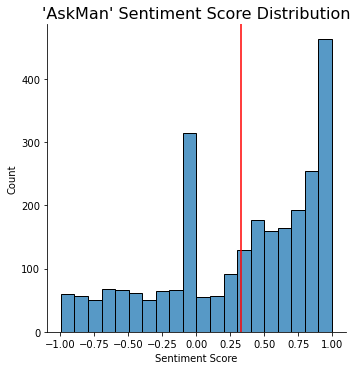

In [ ]:
plt.tight_layout()
sns.displot(df_man_sentiment.score, bins=20)
plt.xlabel("Sentiment Score", size=10)
plt.ylabel("Count", size=10)
plt.axvline(x=df_man_sentiment.score.mean(),
            color='red')
plt.title("'AskMan' Sentiment Score Distribution", size = 16)
plt.savefig('../resources/AskManSantiment.png')


AskWoman submissions

In [16]:
result=[]

for wcomment in final_df[final_df["sex"]==0]["comment"]:    
    score=sent.polarity_scores(wcomment)
    temp={"comment":wcomment,"score":score["compound"]}
    result.append(temp)
df_woman_sentiment=pd.DataFrame(result)
df_woman_sentiment.sort_values(by="score",ascending=False)

,comment,score
1216,so this friend call her old friend and know each other since grade even though didn really talk much until the start high school now re university different university by the way she and this other friend the two people mostly talk throughout high school meet another friend call she the new friend my last year high school and after few year know she she ask for number and that when real...,0.9993
1432,this get bit long but feel the detail important couple week ago this girl match with tinder she cute but not your stereotypical beauty someone that definitely my league she immediately comment how cute one my photo and after few text she ask to hang out later that night work early we end hang out but exchange handful more text that night and the next morning she ask hang out agai...,0.9988
45,this get bit long but feel the detail important couple week ago this girl match with tinder she cute but not your stereotypical beauty someone that definitely my league she immediately comment how cute one my photo and after few text she ask to hang out later that night work early we end hang out but exchange handful more text that night and the next morning she ask hang out agai...,0.9987
144,really random thought here but just wonder young woman myself and just find that girl extremely rude and aggressive towards one another and not only that but also fake have few good friend that woman they cool and love they but sometimes their about they attitude so nasty for reason ask one they simple question and she get irritated and nastywith that other friend decide step and...,0.9983
1935,for context friend and good friend since grade now marry husband friend visit from florida month after move california re still settle but think good idea come for his which the time think too aslong have job well get that job and not the kind job just call off willy nilly just request off whenever express that since new job go to able take too much time off ...,0.9979
...,...,...
533,when have sex all she want for to fuck she and that it let finger she anything else literally just kiss and fuck honestly the bad sex ever effort one side but because like she and ignore all not meet once through out the short relationship she odd thing like say fuck here outside and course that but then second later bring something about she rape when ask she feel like she genui...,-0.9912
1307,to brother thank for home early and showering normally have very short min time frame every weekday when home alone perfect time frame quickly shower put clean hygiene product and throw away the waste the garbage outside without someone hover over it plan plan all day didn want step outside room and mother I question every move and watch like hawk but you ruin think you have precious jo...,-0.9920
1927,don like passive aggressiveness none my friend passive aggressive the bad the friend that get her feeling little bit and have mood swing but mean husband friend marry passive aggressive mean girl she act like friend front other but she ignore roll her eye turn her back dish backhand comment husband friend enable the behavior and join with she she scheme new way bully so dread each time see she...,-0.9945
322,anyone else just get sick around your partner family feel terrible for say this but just want unbiased opinion his family big socializer his several auntie and mum drink regularly together and see each other every weekend don get wrong love close family bond but when they start drink they start talk shit about everyone and even between themselves almost contest between all they about their kid...,-0.9947


Plotting AskWoman submission scores

<Figure size 432x288 with 0 Axes>

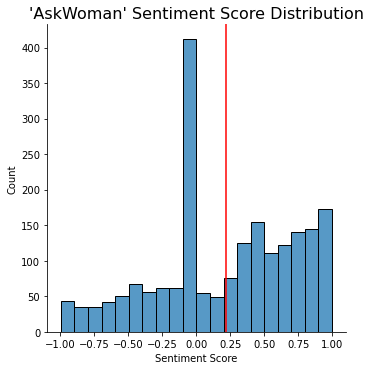

In [17]:
plt.tight_layout()
sns.displot(df_woman_sentiment.score, bins=20)
plt.xlabel("Sentiment Score", size=10)
plt.ylabel("Count", size=10)
plt.axvline(x=df_woman_sentiment.score.mean(),
            color='red')
plt.title("'AskWoman' Sentiment Score Distribution", size = 16)
plt.savefig('../resources/AskWomanSantiment.png')


----

##### Check for outliers

/Users/glebradchenko/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


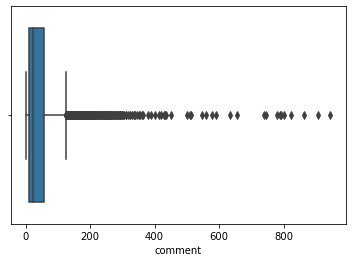

In [18]:

plt.tight_layout()
sns.boxplot(final_df['comment'].str.split(" ").str.len())
plt.savefig('../resources/BoxPlot.png')

There are 72 rows with text length more than 3 standart deviations. Concidering, that these values occured not because of the technical error I'll keep them.

In [19]:
final_df[(np.abs(stats.zscore(final_df["comment"].str.len())) > 3)]


,comment,sex
81,over here canada have some restriction currently place that shut down lot social place our restaurant take out only right now and bar completely close use occasionally to the club and social when have the opportunity but even then people restrict their table and really hinder the social part not currently school right now don have that social aspect my life meet people and interact understand ...,1
85,worry that just deny because feel ashamed think lose this isn the case honest don have issue he want sleep with other girl understand some people just like that and want he happy use have issue with as lie I when find out hit this other woman while say want exclusive but don anymore however have issue with dishonesty also portray lot thing differently the begin our relationship like how strong...,1
181,this difficult one date this girl for and half month and date with she our date generally really good and she act interest she the sweetest most lie back lady meet think myself this too good true she like kiss and have sex the date she take back her place hell yesterday morning she cook breakfast for from her own heart while sit and watch good point her dad know about and ...,1
208,so just get out year relationship not too long ago about over month and the break come for awhile only couple day later the person have lot history he in ex coworker and use just have casual sex texte we then few night later have sex and pick up and intention sleepover his apartment cuddle which never happen before and watch netflix the next morning and take home nothing m...,1
246,hey guy year old man here my final year university date for the past year and leave disillusioned and weary really lose interest it because haven make much headway after year all friend this point seem atleast one two relationship under their belt just feel like miss out the most fun year my life term date and sex and hard not feel negative and angry about we in our prime ...,1
...,...,...
3816,tldr lot movie and show have unnecessary scene especially write man and just wonder how you guy feel about the story author when you see these thing especially when frequently in perverse way long version for abhor pe scene especially they unnecessary frequent and have purpose sometimes even loathe own gender when watch scene where the scene make out sexy with show try show the sex part it mor...,0
3843,english not first language ex and meet university re study together now re from latin america she an instagram model didn have social medium she make one from day one meet school click quickly agree not involve emotionally amp give year she don marry she shoot when not around she text to know where amp keep call texting until join she and her friend we use hang out every day week after kiss am...,0
3866,talk this girl for little bit now she be friend now for long time very many year not like close like friendzone anything but recently kind start talk again recently out narcissistically abusive relationship end there decent chance this girl talk quite narcissist imagine the easy good way give you impression this new girl she kind like trailer park trashy loud fun around always talk about every...,0
3935,not quite sure this the appropriate sub but here go and sorry kind of long don get wrong really like wear earring wear they pretty consistently until high school and almost always they stud as mom call they keep earring however have bad habit lose one the two stud render the remain one practically useless don wear earring very much now mainly because they hurt but also because don buy cute ear...,0


##### Dropping Stopwords

In [20]:
# I am using both SpaCy and nltk colections, as they are slightly different
def drop_stopwords(str):
    result=""
    for word in str.split(' '):
        if word not in nlp.Defaults.stop_words:
            if word not in stopwords.words('english'):
                result+=word
                result+=" "

    return result.strip()

In [21]:
df=final_df.copy()
df['comment']=df['comment'].apply(lambda x: drop_stopwords(x))
df=df[df['comment']!=""]

df

,comment,sex
0,time relationship disinterested second,1
1,big crush boyfriend hand holding afraid,1
2,man manipulate gaslight girl core intention like girl leave aware thank,1
3,real example hey council pick friday home help bed frame sidewalk switch shift dinner plan steak pasta shop male housemate steak sound good send meme hey clock work I know invite happen tuesday awk friend amp iron thing male friend send meme sound good hey boss end extended meeting need reschedule dinner mum come early meet person time nah way manage send question i...,1
4,ok situation happen lot sit friend friend friend leave sit talk awkward,1
...,...,...
4067,encounter issue,0
4068,think thing person hold face hand kiss suppose super hot super romantic wonder think,0
4069,usually listen music watch movie,0
4070,comment hookup outfit,0


Saving point

In [ ]:
#saving file
df.to_csv("../data/df_submissions.csv",index=False)

In [22]:
df["sub_word_count"]=df['comment'].str.split(" ").str.len()
df["sub_length"]= df['comment'].str.len()

In [23]:
df.sort_values(by="sub_word_count")

,comment,sex,sub_word_count,sub_length
1559,reply,1,1,5
2494,hit,0,1,3
3743,end,0,1,3
3310,know,0,1,4
272,long,1,1,4
...,...,...,...,...
3488,bit long feel detail important couple week ago girl match tinder cute stereotypical beauty definitely league immediately comment cute photo text ask hang later night work early end hang exchange handful text night morning ask hang night busy forget reply persistent meet intrigue figure know want end night later decent time bar feel natural hit lot common friend pretty drunk touch...,0,429,2366
2101,bit long feel detail important couple week ago girl match tinder cute stereotypical beauty definitely league immediately comment cute photo text ask hang later night work early end hang exchange handful text night morning ask hang night busy forget reply persistent meet intrigue figure know want end night later decent time bar feel natural hit lot common friend pretty drunk touch...,0,451,2499
2739,sister turn day ago mum british bear pakistani come like ton brick regard marriage sister toxic childish manipulate argumentative immature think mum pick want rid regardless good day sister nice girl introverted speak guy life mind relationship awkward old fashioned regard sex dating etc speak marriage want marry mum desperate sister find lot poor experience fail arrange...,0,452,2637
3734,hi hope write right place read red flag relationship early know relationship toxic ex meet bf november sweet approach different way boy catch speak spiritually manifestation love language interested lot heal journey lose dad lose father similar way connect long list red flag relationship thing possibly wrong want right away insist know care know ily early b...,0,460,1887


##### EDA by subreddits

In [24]:
df.groupby('sex').agg(['mean',"max","min"])

sub_word_count           sub_length          
              mean  max min        mean   max min
sex                                              
0        21.473317  529   1  122.098254  2702   1
1        29.674168  369   1  167.227984  2062   2

Submissions at AskMan are 40 percents longer, than at AskWoman and have 25 percent more words. But the longest by length and by words amount submissions are in AskWoman section.

Plot of words and submission length distributions

<Figure size 432x288 with 0 Axes>

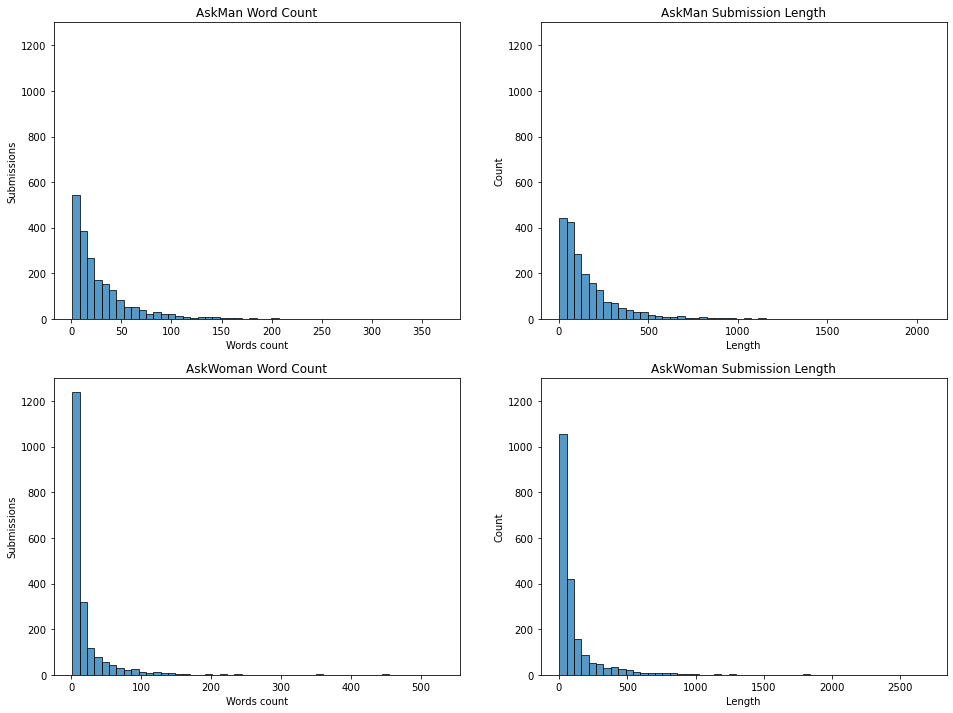

In [25]:
plt.tight_layout()

plt.subplots_adjust(hspace=.2)
plt.figure(figsize=(16,12))
plt.subplot(2, 2, 1)
#AskMan Word Count
plt.title('AskMan Word Count')
sns.histplot(df[df["sex"]==1]['sub_word_count'],bins=50,)
plt.ylim(0, 1300)
plt.xlabel('Words count')
plt.ylabel('Submissions')
#AskMan Submission Length
plt.subplot(2, 2, 2)
plt.title('AskMan Submission Length')
sns.histplot(df[df["sex"]==1]['sub_length'],bins=50)
plt.ylim(0, 1300)
plt.xlabel('Length')
plt.ylabel('Count')
#AskWoman Word Count
plt.subplot(2, 2, 3)
plt.title('AskWoman Word Count')
sns.histplot(df[df["sex"]==0]['sub_word_count'],bins=50,)
plt.ylim(0, 1300)
plt.xlabel('Words count')
plt.ylabel('Submissions')
#AskWoman Submission Length
plt.subplot(2, 2, 4)
plt.title('AskWoman Submission Length')
sns.histplot(df[df["sex"]==0]['sub_length'],bins=50)
plt.ylim(0, 1300)
plt.xlabel('Length')
plt.ylabel('Count')

plt.savefig('../resources/Distribution_submissions.png')
plt.show()

##### Summary

Word count statisticks

In [26]:
print(df[df["sex"]==1]['sub_word_count'].describe())
df[df["sex"]==0]['sub_word_count'].describe()

count    2044.000000
mean       29.674168
std        35.007859
min         1.000000
25%         8.000000
50%        18.000000
75%        39.000000
max       369.000000
Name: sub_word_count, dtype: float64


count    2005.000000
mean       21.473317
std        40.374296
min         1.000000
25%         5.000000
50%         8.000000
75%        20.000000
max       529.000000
Name: sub_word_count, dtype: float64

Submission length statisticks

In [ ]:
df[df["sex"]==1]['sub_length'].describe(),df[df["sex"]==0]['sub_length'].describe()

(count    2044.000000
 mean      165.909980
 std       193.793987
 min         2.000000
 25%        48.000000
 50%       103.500000
 75%       213.000000
 max      2052.000000
 Name: sub_length, dtype: float64,
 count    2005.000000
 mean      121.145636
 std       217.865067
 min         1.000000
 25%        30.000000
 50%        52.000000
 75%       117.000000
 max      2660.000000
 Name: sub_length, dtype: float64)

Heatmap

<AxesSubplot:>

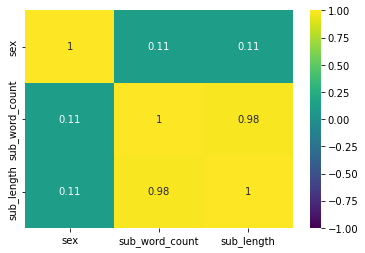

In [27]:
sns.heatmap(df.corr(),annot=True, vmin=-1,vmax=1,cmap="viridis")

Strong correaltion between word count, and submission lenght. But that is essential.

Pairplot

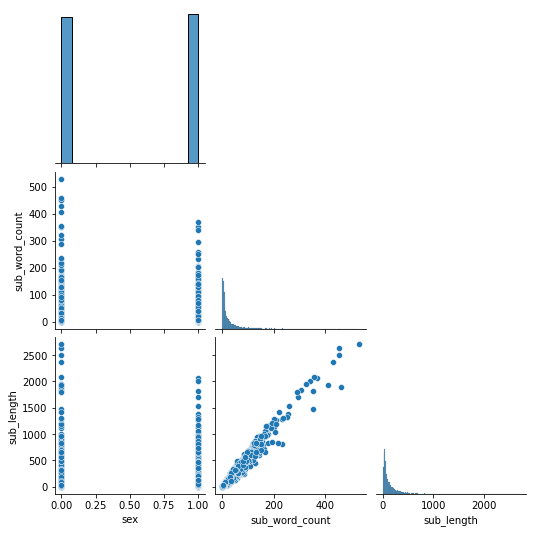

In [28]:
sns.pairplot(df,corner=True)

Strong correaltion between word count, and submission lenght. But that is essential.

_____
##### Finding bigrams

In [29]:

def bigrams_clean(list_f):
    try:
       for x in list_f:
         if x=="":
          return "np.NAN"
         elif x==" ":   
            return "np.NAN"
         else:

            return list_f
          
    except:
       p=1


In [30]:
bigram_freq = lambda s: list(nltk.FreqDist(nltk.bigrams(s.strip().split(" "))).items())

out = df['comment'].apply(bigram_freq).explode()


out = pd.DataFrame(out.to_list(), index=out.index, columns=["submissions", "bigrams"])
#bigram made some mistakes, so I had to make cleaning
for x,k in enumerate(out.iloc[:,0]):
    try:
        if k[0]=="":
            out.iloc[x,0]=np.nan
        if k[1]=="":
            out.iloc[x,0]=np.nan
    except:
        p=1
out=out.dropna()
bigram_count=out["submissions"].value_counts().head(20)

Plotting a bar graph of the most frequnt bigrams


/Users/glebradchenko/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<Figure size 432x288 with 0 Axes>

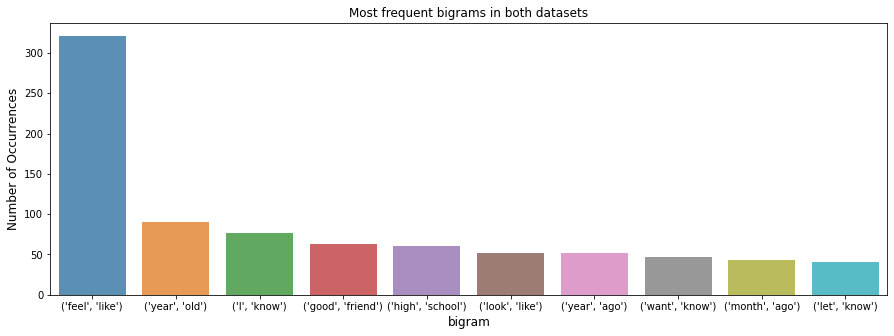

In [31]:
# Plotting a bar graph of the most frequnt bigrams
plt.tight_layout()
bigram_count = bigram_count[:10,]
plt.figure(figsize=(15,5))
sns.barplot(bigram_count.index, bigram_count.values, alpha=0.8)
plt.title('Most frequent bigrams in both datasets')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('bigram', fontsize=12)
plt.savefig('../resources/bigrams.png')
plt.show();

Most of bigrams are basic expressions and common words pairs

In [ ]:
bigram_freq = lambda s: list(nltk.FreqDist(nltk.trigrams(s.split(" "))).items())

out = df['comment'].apply(bigram_freq).explode()
out = pd.DataFrame(out.to_list(), index=out.index, columns=["submissions", "bigrams"])
for x,k in enumerate(out.iloc[:,0]):
    try:
        if k[0]=="":
            out.iloc[x,0]=np.nan
        if k[1]=="":
            out.iloc[x,0]=np.nan
        if k[2]=="":
            out.iloc[x,0]=np.nan
    except:
        p=1
out=out.dropna()
trigram_count=out["submissions"].value_counts().head(20)

/Users/glebradchenko/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<Figure size 432x288 with 0 Axes>

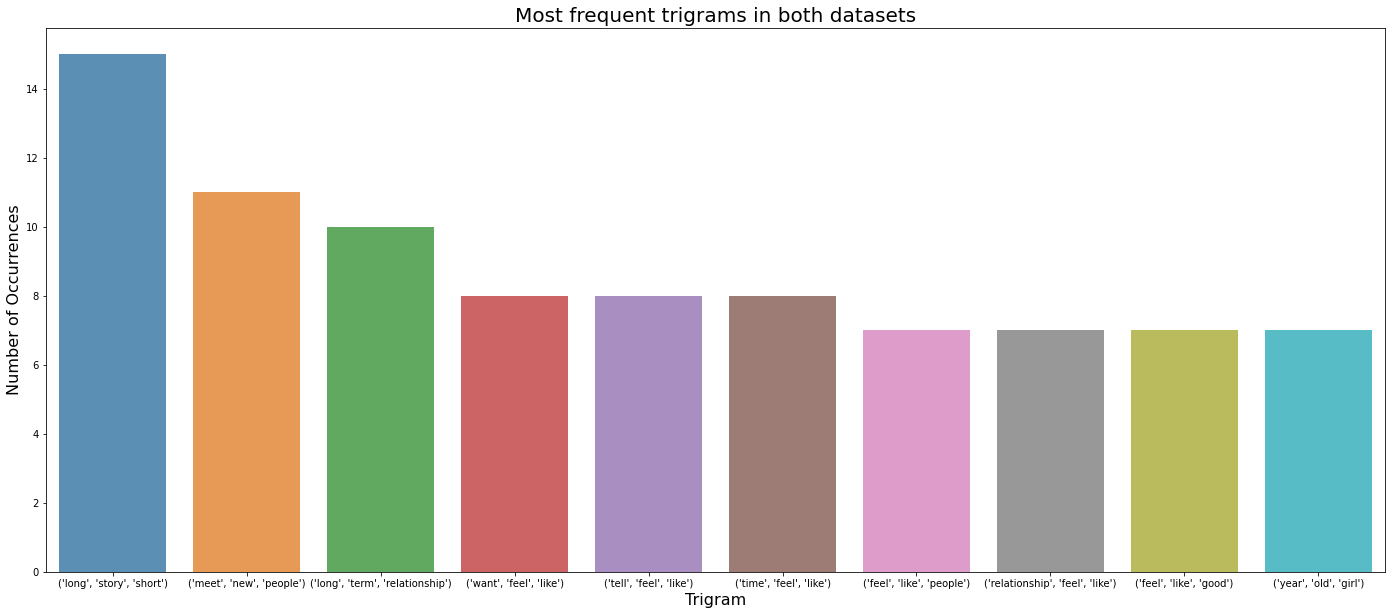

In [ ]:
# Plotting a bar graph of the most frequnt bigrams
plt.tight_layout()
trigram_count = trigram_count[:10,]
plt.figure(figsize=(24,10))
sns.barplot(trigram_count.index, trigram_count.values, alpha=0.8)
plt.title('Most frequent trigrams in both datasets',fontsize=20)
plt.ylabel('Number of Occurrences', fontsize=16)
plt.xlabel('Trigram', fontsize=16)
plt.xticks(fontsize=10)
plt.savefig('../resources/trigrams.png')
plt.show();

All of those are basic expressions.

----
Tokenization and most frequent words

In [33]:
def get_tokens(docs):
    df_tokens = []
    for x in docs:
        man=nlp(x)
        for token in man:
            t_dict = {
            'text': token,
            'POS': token.pos_,
            'POS explained': spacy.explain(token.pos_),        
            'lemma': token.lemma_
            }
            df_tokens.append(t_dict)
        
    return pd.DataFrame(df_tokens)

In [34]:
docs_man = list(nlp.pipe(df[df['sex']==1]["comment"]))
docs_woman = list(nlp.pipe(df[df['sex']==0]["comment"]))

In [35]:
df_man_tokens=get_tokens(docs_man)
df_woman_tokens=get_tokens(docs_woman)


In [39]:
df_man_tokens=df_man_tokens[df_man_tokens["POS"]!="AUX"]
df_man_tokens=df_man_tokens[df_man_tokens["POS"]!="SPACE"]
df_woman_tokens=df_woman_tokens[df_woman_tokens["POS"]!="SPACE"]
df_woman_tokens=df_woman_tokens[df_woman_tokens["POS"]!="SPACE"]


In [43]:
df_man_tokens.shape,len(set(df_man_tokens.lemma)),df_woman_tokens.shape,len(set(df_woman_tokens.lemma))

((52380, 4), 5964, (37435, 4), 5097)

From 2050 submissions we got 5964 unique words for AskMan and 5097 unique words for AskWoman.

In [38]:
df_man_tokens.reset_index(inplace=True)
df_man_tokens.drop(columns='index',inplace=True)

/Users/glebradchenko/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<Figure size 1080x1080 with 0 Axes>

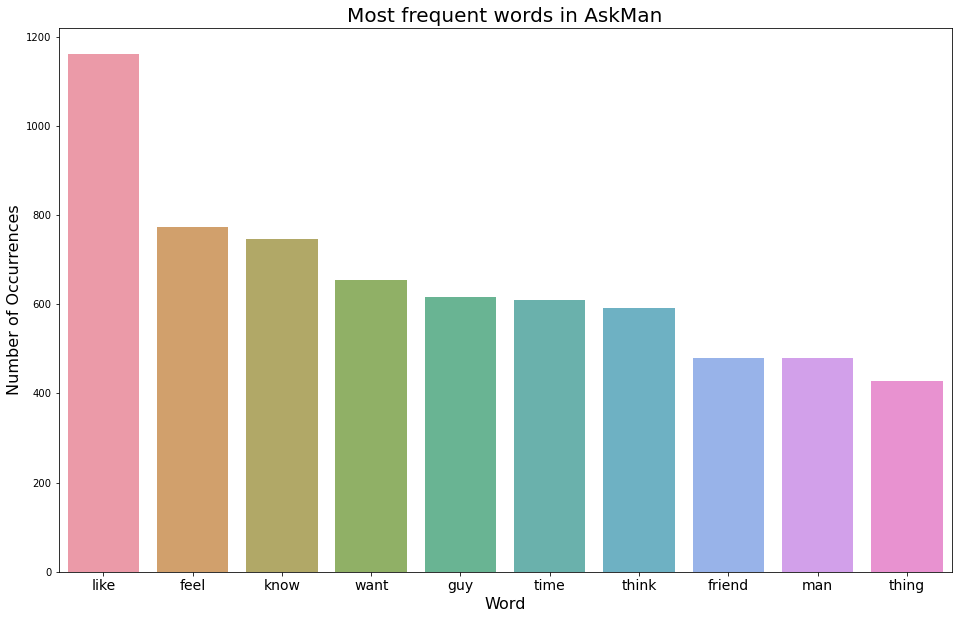

In [ ]:
plt.figure(figsize=(15,15))
man_count=df_man_tokens["lemma"].value_counts().sort_values(ascending=False).head(10)


# Plotting a bar graph of the most frequnt words
plt.tight_layout()
plt.figure(figsize=(16,10))
sns.barplot(man_count.index, man_count.values, alpha=0.8,palette='husl')
plt.title('Most frequent words in AskMan',fontsize=20)
plt.ylabel('Number of Occurrences', fontsize=16)
plt.xlabel('Word', fontsize=16)
plt.xticks(fontsize=14)
plt.savefig('../resources/AskManWords.png')
plt.show()

These words are so common and being used so often, that we can try to consider them as stopwords to see if that will affect modeling effectiveness.


### Now let's look at the most popular words in the AskWoman section

/Users/glebradchenko/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


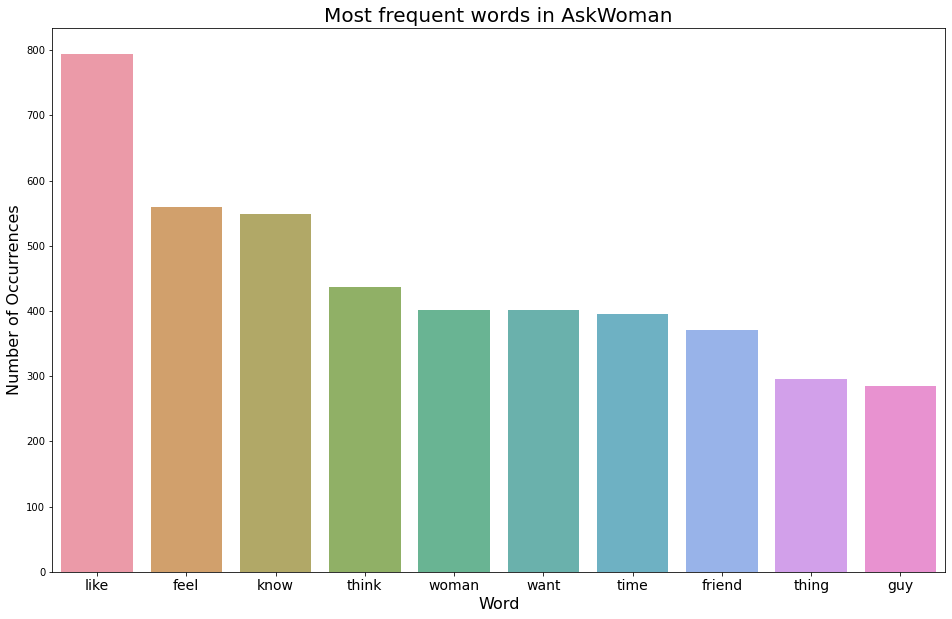

In [ ]:
df_woman_tokens=df_woman_tokens[df_woman_tokens["POS"]!="AUX"]
df_woman_tokens=df_woman_tokens[df_woman_tokens["POS"]!="SPACE"]
# df_woman_tokens=df_woman_tokens[df_woman_tokens["POS"]!="PROPN"]
df_woman_tokens.reset_index(inplace=True)
df_woman_tokens.drop(columns='index',inplace=True)
woman_count=df_woman_tokens["lemma"].value_counts().sort_values(ascending=False).head(10)

# Plotting a bar graph of the most frequnt words
plt.tight_layout()
plt.figure(figsize=(16,10))
sns.barplot(woman_count.index, woman_count.values, alpha=0.8,palette='husl')
plt.title('Most frequent words in AskWoman',fontsize=20)
plt.ylabel('Number of Occurrences', fontsize=16)
plt.xlabel('Word', fontsize=16)
plt.xticks(fontsize=14)
plt.savefig('../resources/AskWomanWords.png')
plt.show()

Same here,these words are so common and being used so often, that we can try to consider them as stopwords to see if that will affect modeling effectiveness.


In [32]:
df_man_tokens

NameError: name 'df_man_tokens' is not defined